In [1]:
import keras

/usr/local/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
import pandas as pd
import numpy as np
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn import preprocessing
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, GRU, SimpleRNN
from tensorflow.keras import regularizers

In [4]:
data=pd.read_csv("sensor.csv")

In [5]:
dataset=pd.DataFrame(data)

Data preprocessing

In [6]:
dataSet=dataset.drop("timestamp",axis=1)
dataset1=dataSet.drop("Unnamed: 0",axis=1) #remove the first two columns which do not refer to sensor data 
dataset1=dataset1.drop("sensor_15",axis=1)#all the values of sensor 15 are NaN

In [7]:
length,features=data.shape
sensors=dataset1.columns[0:-1]

I replace all the Nan values in each sensor with the mean of the rest sensor outputs in the specific sensor that the value is in

In [8]:
for sensor in sensors:
    for value in range(len(dataset1[sensor])):
        if math.isnan(dataset1[sensor][value]):
            dataset1[sensor][value]=dataset1[sensor].mean()

<ipython-input-8-292cfe12da02>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1[sensor][value]=dataset1[sensor].mean()


A list with the different machine conditions 

In [9]:
machine_states = list(dataset.machine_status.unique())
machine_states

['NORMAL', 'BROKEN', 'RECOVERING']

In [10]:
dataset.machine_status.value_counts()/length

NORMAL        0.934259
RECOVERING    0.065709
BROKEN        0.000032
Name: machine_status, dtype: float64

Use the min max scaller for the normalisation

In [11]:
dataset1=dataset1.iloc[:,:-1]

In [12]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler with feature range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_sensor_data = scaler.fit_transform(dataset1)


In [13]:
dataset1=pd.DataFrame(scaled_sensor_data)#!!!

In [14]:
X = dataset1.values
y=dataset.iloc[:,-1].values

I separate diferent machine statuses :normal,recovering and broken

In [15]:
#wherever i put dataset i have changed it from dataset1 
normal=[]
recovery=[]
broken=[]
dataset["machine_status"]
for i in range(len(dataset["machine_status"])):
    if dataset["machine_status"][i]=="NORMAL":
        normal.append(i)
    elif dataset["machine_status"][i]=="RECOVERING":
        recovery.append(i)
    else:
        broken.append(i)

In [16]:
fdata=pd.DataFrame(dataset1)
fdata

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.967194,0.830145,0.876660,0.884816,0.792242,0.764598,0.602472,0.683630,0.638905,0.602141,...,0.027367,0.045424,0.014256,0.133858,0.071489,0.039791,0.245946,0.093853,0.221660,0.178571
1,0.967194,0.830145,0.876660,0.884816,0.792242,0.764598,0.602472,0.683630,0.638905,0.602141,...,0.027367,0.045424,0.014256,0.133858,0.071489,0.039791,0.245946,0.093853,0.221660,0.178571
2,0.959089,0.834736,0.876660,0.890052,0.797904,0.735461,0.598568,0.679645,0.640988,0.600405,...,0.027367,0.044746,0.013959,0.132874,0.072330,0.039791,0.242162,0.092531,0.219875,0.180952
3,0.965264,0.830145,0.874763,0.890052,0.784402,0.769891,0.598243,0.688535,0.644259,0.603299,...,0.026627,0.042712,0.013662,0.130905,0.072330,0.039791,0.242162,0.091870,0.218982,0.180357
4,0.959475,0.830910,0.876660,0.890052,0.794855,0.765891,0.599870,0.687002,0.644259,0.603299,...,0.026627,0.044068,0.013365,0.131890,0.074012,0.041885,0.246487,0.091210,0.220768,0.178571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,0.944423,0.840857,0.759013,0.693717,0.792678,0.645910,0.679245,0.705702,0.642474,0.606482,...,0.022929,0.035932,0.043659,0.088583,0.063919,0.050262,0.347568,0.290152,0.159958,0.209226
220316,0.941721,0.840857,0.760911,0.693717,0.787887,0.658337,0.680872,0.707848,0.642474,0.604745,...,0.022189,0.035932,0.042174,0.082677,0.063078,0.049215,0.350270,0.296100,0.159958,0.209226
220317,0.940178,0.840857,0.759013,0.693717,0.781644,0.672945,0.677944,0.707848,0.644259,0.604745,...,0.022929,0.037966,0.040689,0.076772,0.063078,0.049215,0.356757,0.294118,0.159958,0.210119
220318,0.944037,0.840857,0.759013,0.693717,0.793839,0.650918,0.679245,0.702023,0.646044,0.604745,...,0.022929,0.042034,0.039501,0.072835,0.063919,0.048168,0.366486,0.290813,0.159958,0.212202


In [17]:
time=np.linspace(0,length,length)
drawNormal=np.zeros(length)
drawRecovery=np.zeros(length)
drawBroken=np.zeros(length)
for i in normal:
     drawNormal[i]=dataset1.values[:,0][i]
for i in recovery:
     drawRecovery[i]=dataset1.values[:,0][i]
for i in broken:
     drawBroken[i]=1

Plot with the behavior of the mean value of the 51 sensors. When the red line is in 0 the condition is NORMAL or RECOVERING. When it is 1 the condition is BROKEN

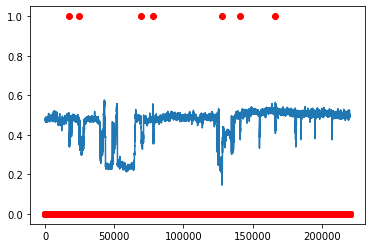

In [18]:
time_means=[]
for i in range(length):
    time_means.append(X[i,:].mean())
plt.plot(time_means)
plt.scatter(time,drawBroken,color="r")

In [19]:
print (broken)

[17155, 24510, 69318, 77790, 128040, 141131, 166440]


Plot of the behavior of 15 sensors 50 timesteps before and 50 timesteps after the first broken incident

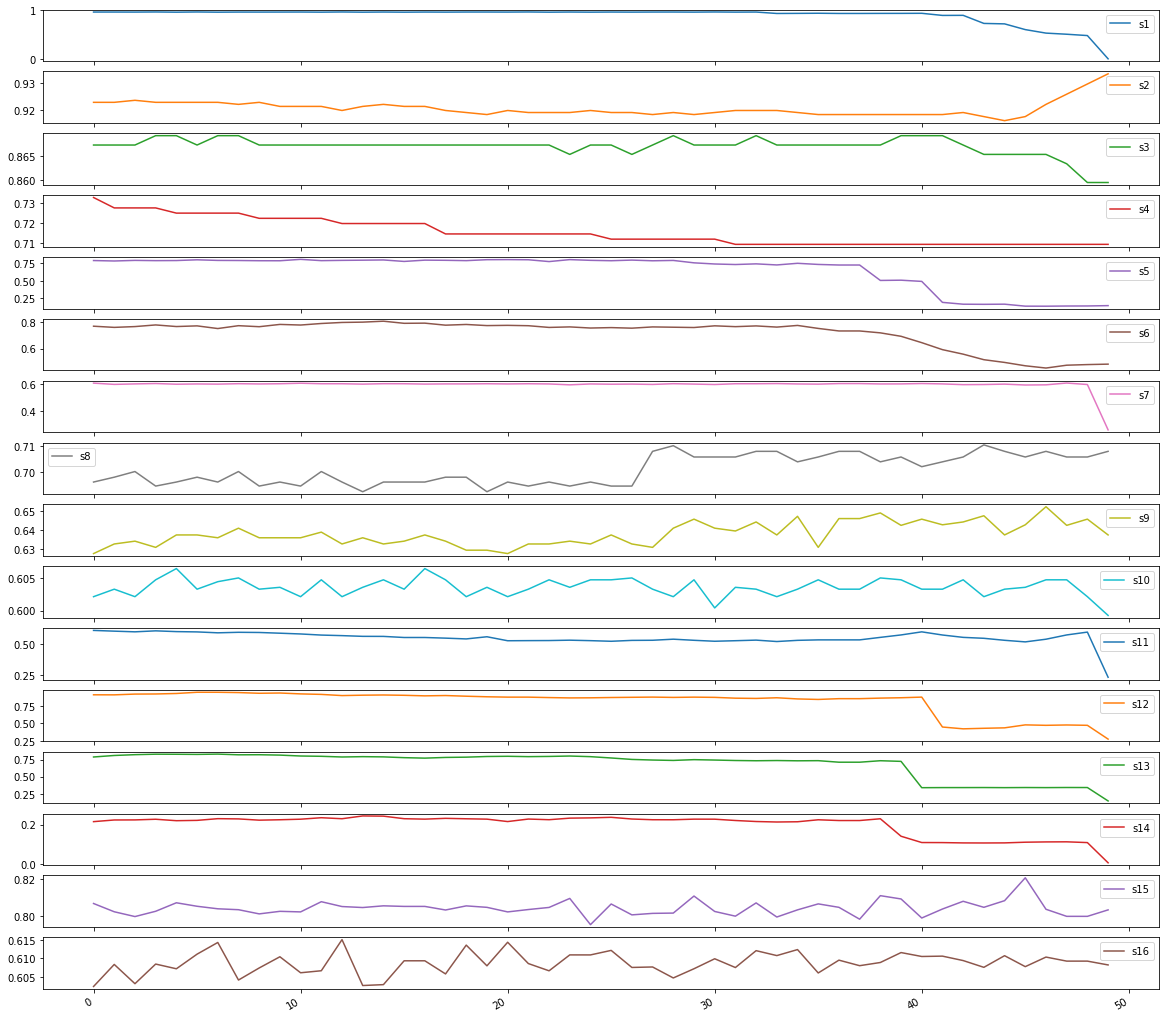

In [20]:
sequence_length=100
starting_index_before_broken=broken[0]-50
fifty_cycle_window=dataset1.values[starting_index_before_broken:broken[0],:]
cols = {'s1':fifty_cycle_window[:,0],'s2':fifty_cycle_window[:,1],'s3':fifty_cycle_window[:,2],'s4':fifty_cycle_window[:,3],
         's5':fifty_cycle_window[:,4],'s6':fifty_cycle_window[:,5],
         's7':fifty_cycle_window[:,6],'s8':fifty_cycle_window[:,7],
         's9':fifty_cycle_window[:,8],'s10':fifty_cycle_window[:,9],'s11':fifty_cycle_window[:,10],
         's12':fifty_cycle_window[:,11],'s13':fifty_cycle_window[:,12],
         's14':fifty_cycle_window[:,13],'s15':fifty_cycle_window[:,14],'s16':fifty_cycle_window[:,15]
       }
fifty_cycle=pd.DataFrame(data=cols)
ax1=fifty_cycle.plot(subplots=True, sharex=True, figsize=(20,20))


In [21]:
y_value=y

In [22]:
train_test_split="whole_train_set"#i can choose between train_set_0,train_set_1,..,train_set_4...
label_split="whole_label"#i can choose between label_0,...,label_4...
step_size=2
k=5000

Split for test and train sets. I want to train the model using various parts of the set as test sets

In [23]:
def training_testing_split(train,length):
  trainf=[]
  trains=[]
  if train=="train_set_0":
    length=fdata.shape[0]
    train_set=fdata.iloc[:int(length*70/100)]
    test_set=fdata.iloc[int(length*0.7):]

  elif train=="train_set_1":
    train_set=fdata.iloc[int(length*0.3):]
    test_set=fdata.iloc[:int(length*0.3)]#the test set now is the first 30% of the dataset

  elif train=="train_set_2":
    trainf=fdata.iloc[:int(length*0.3)]
    trains=fdata.iloc[int(length*0.6):]

    train_set=pd.concat([trainf,trains])
    test_set=fdata.iloc[int(length*0.3):int(length*0.6)]#the test set now is between 30% and the 60% of the dataset

  
  elif train=="train_set_3":
    trainf=fdata.iloc[:int(length*0.6)]
    trains=fdata.iloc[int(length*0.9):]

    train_set=pd.concat([trainf,trains])
    test_set=fdata.iloc[int(length*0.6):int(length*0.9)]#the test now is between 60% and 90% of the dataset  
  
  elif train=="train_set_4":  
    test_set=fdata.iloc[120000:126000]
    trainf=fdata.iloc[:120000]
    trains=fdata.iloc[126000:]
    train_set=pd.concat([trainf,trains])
  elif train=="train_set_new":
    test_set=fdata.iloc[98904:165000]#30% as the test set
    trainf=fdata.iloc[:98904]
    trains=fdata.iloc[165000:]
    train_set=pd.concat([trainf,trains])
  elif train=="train_set_new_cut":
    test_set=fdata.iloc[98904:165000]#
    trainf1=fdata.iloc[:30000]
    trainf=fdata.iloc[40000:98904]
    trains=fdata.iloc[165000:170000]
    train_set=pd.concat([trainf1,trainf,trains])
  elif train=="train_set_without_last_broken":
    train_set=fdata.iloc[:162000]#validation will start from the 129600th element
  elif train=="train_set_without_last_broken_cut":
    train_set=fdata.iloc[:143000]# The validation here will start from the 128700th element if the validation split is 10%
  elif train=="whole_train_set":
    train_set=fdata

  else:
    return None
  return train_set#trainf,trains#,trainf1

  
train_set=training_testing_split(train_test_split,length)

#trainf=training_testing_split(train_test_split,length)[1]
#trains=training_testing_split(train_test_split,length)[2]
#trainf1=training_testing_split(train_test_split,length)[3]

In [24]:
train_set.shape

(220320, 51)

Do the encoding of the condition

In [25]:
# #HERE I HAVE JUST NORMAL AND BROKEN CONDITIONS all the recovery conditions decrease linearly until they reach a normal condition 
encoded=np.zeros((fdata.shape[0],2))
i=0
while i<(len(y_value)):
  if y_value[i]=="BROKEN":
      encoded[i][0]=1
      i+=1
  elif y_value[i]=="RECOVERING": 
    still_recovering=True
    s=0
    starting_index=i
    while still_recovering:
      s+=1
      i+=1
      if y_value[i]!="RECOVERING":
        still_recovering=False
    
    recovering_escalation=0# Aυξάνεται καθε φορά κατα 1/s οπου s ειναι το σύνολο των recovering instances μεχρι να φτασει σε normal condition
    #Μεσα στη while μετράω πόσα στοιχεία υπάρχουν καθε φορα μεχρι να έχω NORMAL περιστατικό μετα απο τα RECOVERING
    for j in range(starting_index,i):
      recovering_escalation+=1/s
      encoded[j][1]=recovering_escalation
      encoded[j][0]=1-recovering_escalation#the values of the two elements of the array sum up to 1
  else:
    encoded[i][1]=1
    i+=1

In [26]:
encoded[17155:17170]
encoded.shape
broken

[17155, 24510, 69318, 77790, 128040, 141131, 166440]

In [27]:
def negative_check(list):
  for el in list:
    if el>=0:
      return False
    return True

In [28]:
#k is the timestep 


i=encoded.shape[0]-1
list=[]
s1=0
while i>0:
  distances_from_broken_list=[i-b for b in broken]
  tmp=[b for b in distances_from_broken_list if b<=0]#it is a negative value
  if  negative_check(tmp):
    if abs(max(tmp))==k:
      print (i)
      tmp1=1/k
      j=1
      while j<k:
        encoded[i+j][0]=tmp1
        encoded[i+j][1]=1-tmp1#they sum up to one
        tmp1+=1/k
        j+=1
      list.append(s)
  i-=1

161440
136131
123040
72790
64318
19510
12155


Creating the labels for each training_set and test_set that will be used in the cross validation


In [29]:
def label_position_on_the_dataset(label,time_step=1):#choose between label_0,label_1,label_2,label_3,label_4
  if label=="label_0":
    l=[]
    for i in range(sequence_length,train_set.values.shape[0],time_step):
      l.append(encoded[i])
    labels=np.array(l)

  elif label=="label_1":
    l1=[]
    for i in range(test_set.shape[0]+sequence_length,length,time_step):
      l1.append(encoded[i])
    labels=np.array(l1)

  elif label=="label_2":
    l2=[]
    for i in range(sequence_length,trainf.shape[0]+sequence_length,time_step):
      l2.append(encoded[i])
    for j in range(trainf.shape[0]+test_set.shape[0]+sequence_length,length,time_step):
      l2.append(encoded[j])
    labels=np.array(l2)

  elif label=="label_3":
    l3=[]
    for i in range(sequence_length,trainf.shape[0]+sequence_length,time_step):
      l3.append(encoded[i])
    for j in range(trainf.shape[0]+test_set.shape[0]+sequence_length,length,time_step):
      l3.append(encoded[j])
    labels=np.array(l3)
    


  elif label=="label_4":
    l4=[]
    for i in range(sequence_length,trainf.shape[0]+sequence_length,time_step):
        l4.append(encoded[i])
    for j in range(trainf.shape[0]+test_set.shape[0]+sequence_length,length,time_step):
      l4.append(encoded[j])
    labels=np.array(l4)

  elif label=="label_new":

    l5=[]
    for i in range(sequence_length,trainf.shape[0]+sequence_length,time_step):
        l5.append(encoded[i])
    for j in range(trainf.shape[0]+test_set.shape[0]+sequence_length,length,time_step):
      l5.append(encoded[j])
    labels=np.array(l5)

  elif label=="label_new_cut":
    l6=[]
    for i in range(sequence_length,trainf1.shape[0]+sequence_length,time_step):
        l6.append(encoded[i])
    for j in range(40000+sequence_length,40000+trainf.shape[0]+sequence_length,time_step):
        l6.append(encoded[i])
    for k in range(165000+sequence_length,165000+trains.shape[0],time_step):
      l6.append(encoded[j])
    labels=np.array(l6)

  elif label=="label_without_last_broken":
    l7=[]
    for i in range(sequence_length,train_set.shape[0],time_step):
      l7.append(encoded[i])
    labels=np.array(l7)
  elif label=="whole_label":
    l8=[]
    for i in range(sequence_length,train_set.shape[0],time_step):
        l8.append(encoded[i])
    labels=np.array(l8)
  else:
    return None
  return np.array(labels)#,np.array(test_labels)
  

In [30]:
labels=label_position_on_the_dataset(label_split,step_size)
print(labels.shape)

(110110, 2)


Using labels in order to make the prediction after k timesteps

In [31]:
labels=labels[k:]

Changing the labels for k-1 elements before the broken instance

In [32]:
[b for b in broken if b>=0]

[17155, 24510, 69318, 77790, 128040, 141131, 166440]

In [33]:
for i in range(labels.shape[0]-1):
  if labels[i][0]==1:
    print(i)

7205
29609
33845
58970
78170


Shaping the training sequence for the LSTM


In [34]:
def sequence_generator(train_set,step_size=1):
  seq_array=[]
  data_array=train_set.values
  num_elements=data_array.shape[0]

  for start, stop in zip(range(0, num_elements-sequence_length,step_size), range(sequence_length, num_elements,step_size)):#example for sequence_length=150:(0,150),(1,151),(2,152)....,(num-150,num)
    seq_array.append(data_array[start:stop,:])
  sequence_array=np.array(seq_array)
  return sequence_array
sequence_array=sequence_generator(train_set,step_size)

In [35]:
sequence_array.shape

(110110, 100, 51)

In [36]:
labels.shape

(105110, 2)

Removing the broken instances from the training set

In [37]:

sum_broken=0
for i in range(labels.shape[0]):
     if labels[i][0]==1:
       sum_broken+=1
       sequence_array=np.delete(sequence_array[:][:],i-k,axis=0)

In [38]:
sequence_array=sequence_array[:-k]#changing the dimensions of the sequence i dont take the last k

In [39]:
#testing if the dimmensions are right
print(sequence_array.shape)
print(train_set.shape)

(105105, 100, 51)
(220320, 51)


In [40]:
labels[17035:17070]
labels[7567:7600]#For k=1000 17135/2-1000

array([[0.76720257, 0.23279743],
       [0.76655949, 0.23344051],
       [0.7659164 , 0.2340836 ],
       [0.76527331, 0.23472669],
       [0.76463023, 0.23536977],
       [0.76398714, 0.23601286],
       [0.76334405, 0.23665595],
       [0.76270096, 0.23729904],
       [0.76205788, 0.23794212],
       [0.76141479, 0.23858521],
       [0.7607717 , 0.2392283 ],
       [0.76012862, 0.23987138],
       [0.75948553, 0.24051447],
       [0.75884244, 0.24115756],
       [0.75819936, 0.24180064],
       [0.75755627, 0.24244373],
       [0.75691318, 0.24308682],
       [0.7562701 , 0.2437299 ],
       [0.75562701, 0.24437299],
       [0.75498392, 0.24501608],
       [0.75434084, 0.24565916],
       [0.75369775, 0.24630225],
       [0.75305466, 0.24694534],
       [0.75241158, 0.24758842],
       [0.75176849, 0.24823151],
       [0.7511254 , 0.2488746 ],
       [0.75048232, 0.24951768],
       [0.74983923, 0.25016077],
       [0.74919614, 0.25080386],
       [0.74855305, 0.25144695],
       [0.

In [41]:
sequence_array.shape

(105105, 100, 51)

Removing the extra values from the labels

In [42]:
N=labels
labels.shape

(105110, 2)

In [43]:
 # #βαζω σε κατάλληλη μορφη το ten_t_steps_labels 
 a=labels.reshape((len(N),2))
 ten_tsteps_labels=a[:-sum_broken]

In [44]:
print(ten_tsteps_labels.shape)
print(sequence_array.shape)

(105105, 2)
(105105, 100, 51)


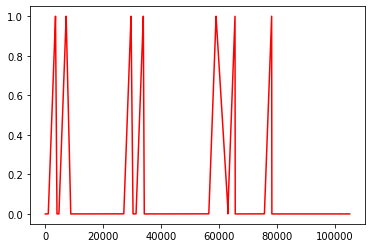

In [45]:
labelplot=[]
for i in range(labels.shape[0]):
  labelplot.append(labels[i][0])
plt.figure()
plt.plot(labelplot,"r")


LSTM network

In [46]:
def model_generator(sequence_array,labels,sequence_length):
  nfeatures=sequence_array.shape[2]
  n_out=labels.shape[1]
  model=Sequential()
  model.add(LSTM(units=sequence_length,
               input_shape=(sequence_length,nfeatures),
               return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

  model.add(Dense(units=n_out,activation='softmax'))#δοκιμη με softmax 
  opt=keras.optimizers.Adam(learning_rate=0.0001)#i used opt=keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mean_squared_error',optimizer=opt,metrics=['accuracy'])#χρησιμοποιούσα binary_crossentropy και optimizer='adam'
  return model

In [47]:
model=model_generator(sequence_array,ten_tsteps_labels,sequence_length)#model generation to make the prediction after k timesteps
print(model.summary())
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]#να δοκιμασω στο patience διαφορες τιμες 




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               60800     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 61,002
Trainable params: 61,002
Non-trainable params: 0
_________________________________________________________________
None


Fit the model

In [48]:
model.fit(sequence_array,ten_tsteps_labels,epochs=10,batch_size=128,validation_split=0.3,callbacks=my_callbacks)#model fitting to make the prediction after k timesteps big batch value (unbalanced dataset)

Epoch 1/10
575/575 [==============================] - 146s 254ms/step - loss: 0.5562 - accuracy: 0.8503 - val_loss: 0.2609 - val_accuracy: 0.9598
Epoch 2/10
575/575 [==============================] - 143s 249ms/step - loss: 0.1817 - accuracy: 0.8626 - val_loss: 0.1045 - val_accuracy: 0.9598
Epoch 3/10
575/575 [==============================] - 143s 249ms/step - loss: 0.1072 - accuracy: 0.8767 - val_loss: 0.0797 - val_accuracy: 0.9560
Epoch 4/10
575/575 [==============================] - 142s 247ms/step - loss: 0.0824 - accuracy: 0.9039 - val_loss: 0.0718 - val_accuracy: 0.9557
Epoch 5/10
575/575 [==============================] - 142s 246ms/step - loss: 0.0715 - accuracy: 0.9139 - val_loss: 0.0674 - val_accuracy: 0.9559
Epoch 6/10
575/575 [==============================] - 141s 246ms/step - loss: 0.0636 - accuracy: 0.9214 - val_loss: 0.0647 - val_accuracy: 0.9556
Epoch 7/10
575/575 [==============================] - 142s 246ms/step - loss: 0.0583 - accuracy: 0.9287 - val_loss: 0.0615 -

Saving the model

In [49]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [50]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


In [51]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               60800     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 61,002
Trainable params: 61,002
Non-trainable params: 0
_________________________________________________________________


In [52]:
#prediction = new_model.predict(test_ten_tsteps_array)
prediction=new_model.predict(sequence_array)

In [53]:
prediction

array([[0.04052467, 0.9594753 ],
       [0.04002669, 0.95997334],
       [0.03958727, 0.96041274],
       ...,
       [0.00656454, 0.9934355 ],
       [0.00654797, 0.9934521 ],
       [0.00655534, 0.9934447 ]], dtype=float32)

The broken instances inside the train set

In [54]:
label_broken=[]
draw_test_prediction1=[]
for i in range(len(ten_tsteps_labels)):
  draw_test_prediction1.append(prediction[i][0])#used for the fraph of the training set
  if ten_tsteps_labels[i][0]==1:
    label_broken.append(i)
print(label_broken)


[7205, 29609, 33845, 58970, 78170]


In [55]:
label_b=[b-5000 for b in broken]


In [56]:
label_broken=[int(lb/step_size) for lb in label_b]
label_broken
train_validation_label_broken=label_broken[:-1]


In [57]:
train_validation_label_broken

[6077, 9755, 32159, 36395, 61520, 68065]

The predictions for the broken instances

In [58]:
threshold=0.6
prediction_broken=[]
for i in range(len(prediction)):
  if prediction[i][0]>threshold:
    prediction_broken.append(i)
print(prediction_broken)

[2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 280

Preparing for the plotting of the training set


In [59]:

array1=np.zeros(ten_tsteps_labels.shape[0])
count_array1=np.zeros(ten_tsteps_labels.shape[0])
count_elements1=0

for i in range(1,ten_tsteps_labels.shape[0]-1):
  count_array1[i]=count_elements1
  count_elements1+=1
   
  if ten_tsteps_labels[i][0]==1 or (ten_tsteps_labels[i][0]>ten_tsteps_labels[i-1][0] and ten_tsteps_labels[i][0]>ten_tsteps_labels[i+1][0]):
    print(i)
    array1[i]=1


3527
7205
29609
33845
58970
65515
78170


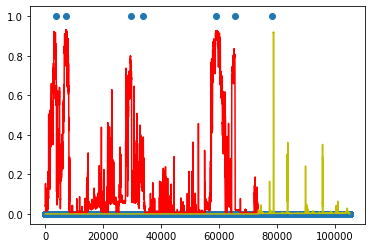

In [60]:
validation_draw=np.zeros(len(draw_test_prediction1))

for i in range(73573,len(draw_test_prediction1)-1):
  validation_draw[i]=draw_test_prediction1[i]
plt.scatter(count_array1,array1)
plt.plot(draw_test_prediction1[:73573],"r")
plt.plot(validation_draw,"y")

In [61]:
train_validation_label_broken

[6077, 9755, 32159, 36395, 61520, 68065]